In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

---
# What does human power output with time look like?

Import [time to exhaustion data](https://www.oocities.org/mdetting/sports/cycling.html)

In [2]:
import pandas as pd
from carpy.utility import GetPath, cast2quantity

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cycling_exhaustion_malewicki.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_athlete = cast2quantity(dfs["athlete"])
data_healthy = cast2quantity(dfs["healthy"])

Create power models

In [3]:
import numpy as np
from carpy.utility import Quantity
from scipy.optimize import curve_fit

def func(x, a, b, c):
    """Exponential model with controlling parameters a, b, and c."""
    return a * np.exp(-b * (x - c))

def cnuf(y, a, b, c):
    """Inverse of func."""
    return np.log(y / a) / -b + c

def compute_sigma(dataset):
    # Initial distribution
    sigma = (np.arange(dataset["power"].size)[::-1] + 1) * 0.1
    sigma **= 1.5
    
    # Raise sigma for anything that isn't the three lowest times
    sigma[np.argsort(dataset["time"].x)[3:]] = 5
    
    return sigma

# Model parameters for an athlete's sustained power output
p0 = (1, 1e-2, max(data_athlete["power"]).x)
popt_athlete, _ = curve_fit(func, data_athlete["power"], data_athlete["time"], p0=p0, sigma=compute_sigma(data_athlete))

# Model parameters for a healthy human's sustained power output
p0 = (1, 1e-2, max(data_healthy["power"]).x)
popt_healthy, _ = curve_fit(func, data_healthy["power"], data_healthy["time"], p0=p0, sigma=compute_sigma(data_healthy))

Visualise the chart to make sure our models make sense

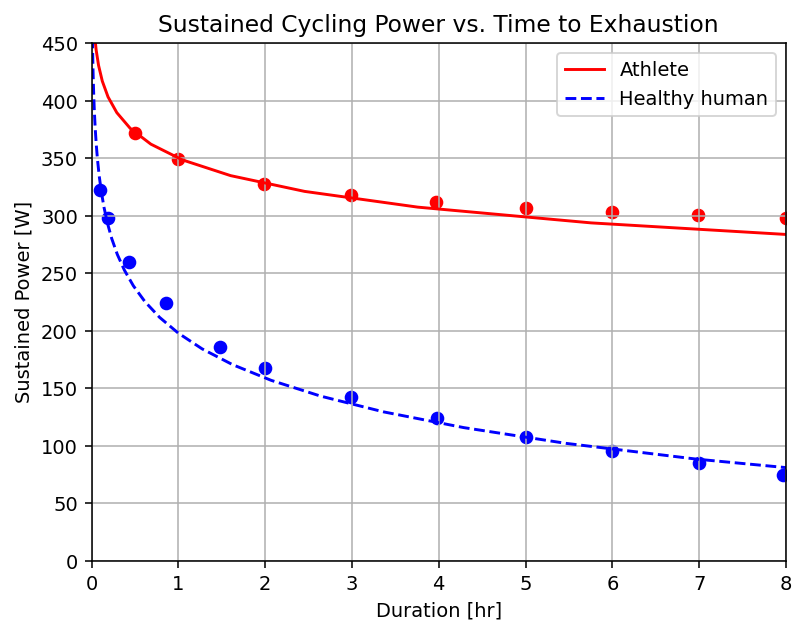

popt_athlete=array([2.68931553e+01, 3.11155374e-02, 5.07334805e+02]);
popt_healthy=array([1.74514260e+01, 1.77213335e-02, 4.98550861e+02])


In [4]:
power = Quantity(np.linspace(0.1, 1), "hp")
time_athlete = Quantity(func(power.to("W"), *popt_athlete), "s")
time_healthy = Quantity(func(power.to("W"), *popt_healthy), "s")

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, dpi=140)

# Plot raw data
ax.scatter(data_athlete["time"].to("hr"), data_athlete["power"], c="red")
ax.scatter(data_healthy["time"].to("hr"), data_healthy["power"], c="blue")

# Plot models
ax.plot(time_athlete.to("hr"), power, c="red", label="Athlete")
ax.plot(time_healthy.to("hr"), power, c="blue", label="Healthy human", ls="--")

ax.set_xlim(0, 8)
ax.set_ylim(0, 450)
ax.set_title("Sustained Cycling Power vs. Time to Exhaustion")
ax.set_xlabel("Duration [hr]")
ax.set_ylabel("Sustained Power [W]")
ax.legend()
ax.grid()
plt.show()

print(f"{popt_athlete=};\n{popt_healthy=}")

We assign fictitious errors to longer endurance runs during curve fitting, to bias the curves to better model short burst performance.
Power outputs for "healthy" and "athletic" humans is close to what Malewicki describes, or is underpredicted.

# Is Malewicki's performance model feasible?

Import [cyclist performance data](https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare) by demographic 

In [5]:
import pandas as pd

# Read the data from the relevant file
excel_path = os.path.join(GetPath.library(), "propulsion\\data\\cyclinganalytics_power.xlsx")
dfs = pd.read_excel(excel_path, sheet_name=None)

data_maleW = cast2quantity(dfs["M W"])
data_femaleW = cast2quantity(dfs["F W"])

> "It’s worth saying a few words about Cycling Analytics users, because they aren’t a perfectly random sampling of cyclists or people overall. The best term that I can think of is that Cycling Analytics users are 'serious cyclists'. All the data here comes from people with power meters, and about half of Cycling Analytics users race regularly."

Plot the percentile of athlete you need to be, to sustain a cycling output of however many watts

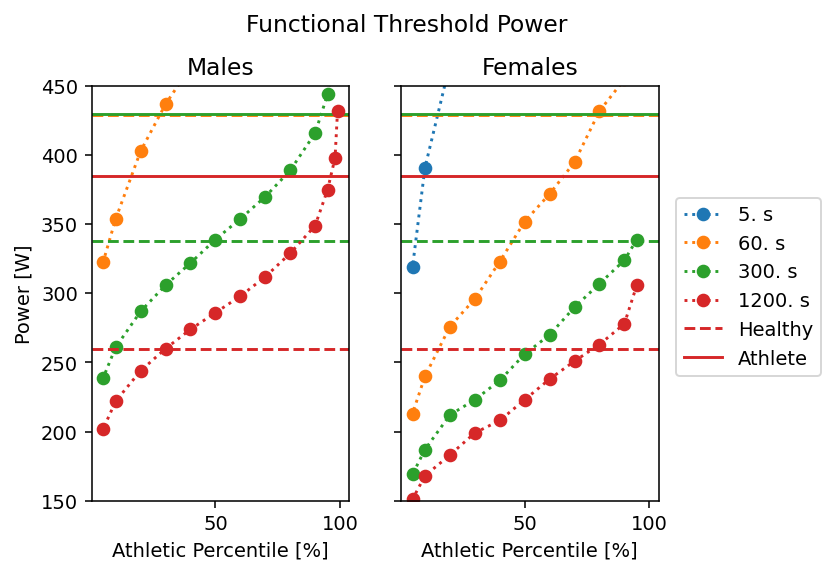

In [6]:
fig, axs = plt.subplots(1, 2, dpi=140, figsize=(6, 4), sharex=True, sharey=True)
fig.suptitle("Functional Threshold Power")
fig.subplots_adjust(top=0.85, right=0.8)

times = Quantity([5, 60, 300, 1200], "s")

for i, dataset in enumerate([data_maleW, data_femaleW]):
    # Plot series data
    for time in times:
        series = f"{int(time.x)}s"
        line, = axs[i].plot(dataset["percentile [%]"], dataset[series], label=time, ls=":", marker="o")
    
        # The power Malewicki thinks a healthy human can produce for the given time
        power_h = Quantity(cnuf(time, *popt_healthy), "s")
        # The power Malewicki thinks an athletic human can produce for the given time
        power_a = Quantity(cnuf(time, *popt_athlete), "s")
        
        # It only makes sense for the athlete to outperform the healthy human
        if power_a >= power_h:
            line_h = axs[i].axhline(power_h, ls="--", c=line.get_color())
            line_a = axs[i].axhline(power_a, ls="-", c=line.get_color())
        
# Make plot pretty
for ax in axs.flat:
    ax.set_xlabel("Athletic Percentile [%]")
else:
    axs[0].set_title("Males")
    axs[1].set_title("Females")
    axs[0].set_ylabel("Power [W]")
    axs[0].set_ylim(150, 450)
    
    handles, labels = ax.get_legend_handles_labels()
    handles += [line_h, line_a]
    labels += ["Healthy", "Athlete"]
    fig.legend(handles=handles, labels=labels, loc="right")
    
plt.show()

Recall that the data in the plot above represents "serious" cyclists, about 50% of which participate in competitions.

##### Malewicki's Healthy Humans

For effort exertion over 20 minutes, male "serious" cyclists in the 30% and higher performance percentile meet Malewicki's performance expectations of healthy humans.
This sustained power output is met by approximately the top ~20% of female "serious" cyclists.

##### Malewicki's Athletes

The data seems to suggest that for a period of 20 minutes, only male "serious" cyclists in the top ~4% of their cohort satisfy Malewicki's definition of an athlete.

# What is the available sustained power for a channel crossing?

Work out the times that it would take to cross the channel at the shortest point, with no wind

In [7]:
channel_dist = Quantity(20.5, "mi")
crossing_speeds = Quantity(np.linspace(0, 15), "m s^{-1}")

crossing_times = channel_dist / crossing_speeds

Plot the crossing speed and the power available for a given crossing time

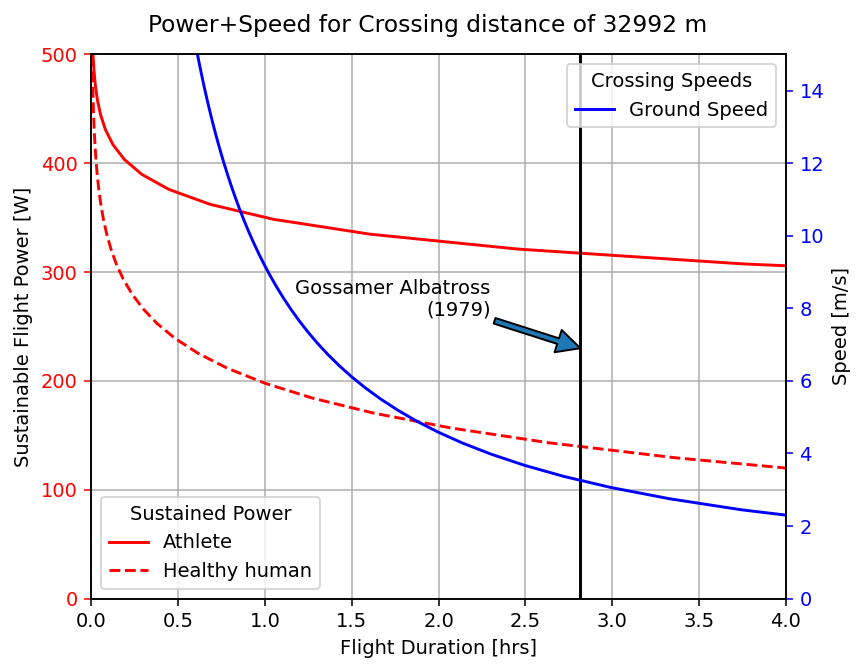

In [8]:
fig, ax = plt.subplots(1, dpi=140)
fig.suptitle(f"Power+Speed for Crossing distance of {channel_dist:.0f}")
fig.subplots_adjust(top=0.92)
ax2 = ax.twinx()

# Plot sustained power
ax.plot(time_athlete.to("hr"), power.to("W"), c="red", ls="-", label="Athlete")
line_p, = ax.plot(time_healthy.to("hr"), power.to("W"), c="red", ls="--", label="Healthy human")


# Plot crossing time
line_t, = ax2.plot(crossing_times.to("hr"), crossing_speeds, ls="-", c="blue", label="Ground Speed")

# Mark out the MacCready Gossamer Albatross' 1979 flight
albatross_t = Quantity(2, "hr") + Quantity(49, "min")
ax.axvline(albatross_t.to("hr"), c="black", ls="-")
ax.annotate(
    "Gossamer Albatross\n(1979)",
    xy=(albatross_t.to("hr"), 230), xytext=(2.3, 260),
    arrowprops={"width":3}, horizontalalignment="right"
)

# Make axis 1 pretty
ax.set_xlim(0, 4)
ax.set_ylim(0, 500)
ax.set_xlabel("Flight Duration [hrs]")
ax.set_ylabel("Sustainable Flight Power [W]")
ax.tick_params(axis="y", colors=line_p.get_color())

# Make axis 2 pretty
ax2.set_ylim(0, max(crossing_speeds))
ax2.set_ylabel("Speed [m/s]")
ax2.tick_params(axis="y", colors=line_t.get_color())

ax.legend(title="Sustained Power", loc="lower left")
ax2.legend(title="Crossing Speeds", loc="upper right")
ax.grid()
plt.show()

---
# Exhaustion with Time modelling

_From "Effect of low recumbent angle on cycling performance, fatigue and $\dot{\text{V}}\text{O}_2$ kinetics"_

In [184]:
# Recumbent performance for 30degree incline from horizontal

from carpy.utility import cast2numpy




def VdotO2_30R(t, n=10):
    """
    Estimate the volumetric flow of oxygen, in Litres per minute,
    for a cyclist in a 30 degree inclined from horizontal posture.
    
    Arguments:
        t: Time (in seconds).
        n: Number of samples to take.
    
    Returns:
        2D array, axis0 = random sample number, axis1 = time-dependent result.

    Notes:
        Not sure why I couldn't reproduce the figures in the paper when
        using exact numbers. I fudged the parameters a little bit so we can
        get the shape of the graph shown in the paper's figures.

    """
    # Recast as necessary
    t = cast2numpy(t)
    
    # Standard distribution
    # stddst = np.random.standard_normal(size=n)
    
    # Baseline oxygen uptake
    VdotO2_base = 0.45  # Fudged this number slightly
    
    # Asymptotic amplitudes for different phases of cycling
    Ac = np.random.normal(0.41, 0.19, n)  # Cardiodynamic
    Ap = np.random.normal(1.52, 0.37, n)  # Primary (estimate)
    As = np.random.normal(0.39, 0.12, n)  # Slow (estimate)
    # Fudge factor
    Ap *= 0.8
    
    # Time constants
    tc = 15
    tp = np.random.normal(21.2, 8.3, n)
    ts = 70
    
    # Time delays
    TDc = 0
    TDp = 26.7 + TDc
    TDs = np.random.normal(124, 22.4, t.size)
    
    # Conditional switching expressions
    Uc = np.where(t > TDc, 1, 0)
    Up = np.where(t > TDp, 1, 0)
    Us = np.where(t > TDs, 1, 0)

    # Performance equation (using random parameters)
    VdotO2 = (
        VdotO2_base
        + Ac * (1 - np.exp(-(t - TDc)[:, None] / tc)) * Uc[:, None]
        + Ap * (1 - np.exp(-(t - TDp)[:, None] / tp)) * Up[:, None]
        + As * (1 - np.exp(-(t - TDs)[:, None] / ts)) * Us[:, None]
    ).T
    
    # Compress randomly generated arrays
    VdotO2 = np.clip(VdotO2, 0, 3).mean(axis=0)
    
    return VdotO2


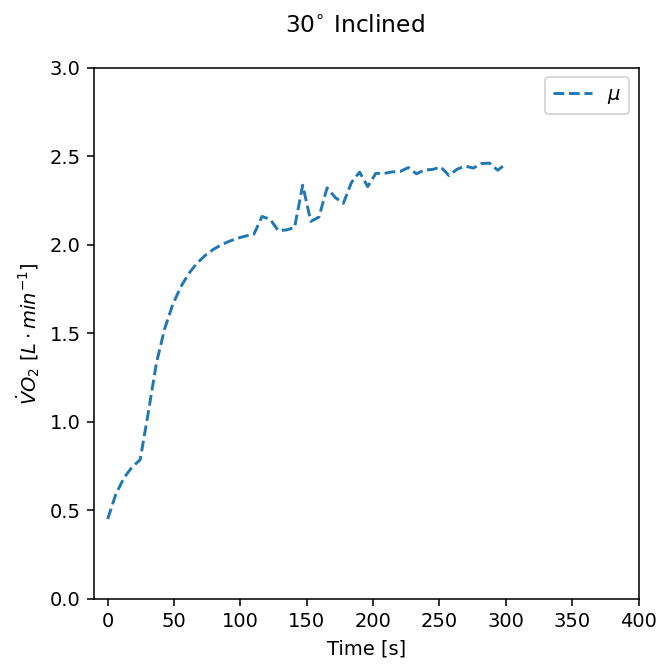

In [185]:
# Create plot
fig, ax = plt.subplots(1, dpi=140)
fig.suptitle("30$^{\circ}$ Inclined")
fig.subplots_adjust(top=0.9)

# Create data
xs = np.linspace(0, 300)
ys = VdotO2_30R(t=xs, n=50)

ax.plot(xs, ys, ls="--", label=r"$\mu$")

ax.set_xlabel("Time [s]")
ax.set_ylabel(r"$\dot{V}O_2$ [$L \cdot min^{-1}$]")
ax.set_xlim(-10, 400)
ax.set_ylim(0, 3)
ax.set_aspect(400/3)
ax.legend()

plt.show()